In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import torch
import torch.nn as nn
import pandas as pd
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
ds_path = "/content/gdrive/MyDrive/Datasets/Cure The Princess"
train_df = pd.read_csv(ds_path+"/cure_the_princess_train.csv")
val_df = pd.read_csv(ds_path+"/cure_the_princess_validation.csv")
test_df = pd.read_csv(ds_path+"/cure_the_princess_test.csv")

In [4]:
train_df.head

<bound method NDFrame.head of       Phoenix Feather  Unicorn Horn  Dragon's Blood  Mermaid Tears  \
0                18.8           1.5            19.7            1.1   
1                 6.0           3.8            12.4           16.9   
2                22.4           7.9            28.6           11.2   
3                10.8           4.6             5.1           16.7   
4                 3.7           5.7             9.0            3.3   
...               ...           ...             ...            ...   
1247             35.6           8.7             8.0           18.3   
1248             23.1           2.5            26.3            4.5   
1249             22.4          19.6             7.4           10.8   
1250             22.5          12.5            24.5           14.2   
1251             12.3          17.6            13.0           11.0   

      Fairy Dust  Goblin Toes  Witch's Brew  Griffin Claw  Troll Hair  \
0           19.5         30.1          16.5           9.

In [5]:
X_train = train_df.drop('Cured', axis=1).values
y_train = train_df['Cured'].values

X_val = val_df.drop('Cured', axis=1).values
y_val = val_df['Cured'].values

X_test = test_df.drop('Cured', axis=1).values
y_test = test_df['Cured'].values

X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)

X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32)

X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

val_dataset = TensorDataset(X_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [6]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.hidden_layer_1 = nn.Linear(13, 100) 
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(p=0.2)
        self.hidden_layer_2 = nn.Linear(100, 50)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(p=0.2)
        self.output_layer = nn.Linear(50, 1) 
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out = self.hidden_layer_1(x)
        out = self.relu1(out)
        out = self.dropout1(out)
        out = self.hidden_layer_2(out)
        out = self.relu2(out)
        out = self.dropout2(out)
        out = self.output_layer(out)
        out = self.sigmoid(out)
        return out

Epoch 0, Training loss: 0.7526, Validation loss: 10.3095
Epoch 1, Training loss: 0.6957, Validation loss: 9.4675
Epoch 2, Training loss: 0.6323, Validation loss: 9.0326
Epoch 3, Training loss: 0.6292, Validation loss: 8.7885
Epoch 4, Training loss: 0.6044, Validation loss: 8.4652
Epoch 5, Training loss: 0.5936, Validation loss: 8.2370
Epoch 6, Training loss: 0.6056, Validation loss: 8.0682
Epoch 7, Training loss: 0.5791, Validation loss: 7.8933
Epoch 8, Training loss: 0.5605, Validation loss: 7.5996
Epoch 9, Training loss: 0.5541, Validation loss: 7.3435
Epoch 10, Training loss: 0.5361, Validation loss: 7.1422
Epoch 11, Training loss: 0.5273, Validation loss: 6.9482
Epoch 12, Training loss: 0.5324, Validation loss: 6.7962
Epoch 13, Training loss: 0.5163, Validation loss: 6.7004
Epoch 14, Training loss: 0.5051, Validation loss: 6.4734
Epoch 15, Training loss: 0.4993, Validation loss: 6.4400
Epoch 16, Training loss: 0.4921, Validation loss: 6.1988
Epoch 17, Training loss: 0.4868, Validat

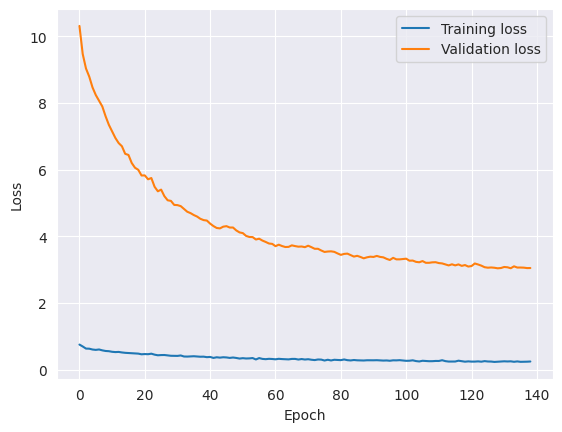

In [7]:
torch.manual_seed(190401060)
mlp = MLP()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
mlp.to(device)

criterion = nn.BCELoss()
list_train_loss, list_val_loss = [], []
best_val_loss = None
optimizer = optim.SGD(mlp.parameters(), lr=0.001)
patience = 10

patience_counter = 0
num_epochs =200
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    train_loss = 0.0
    val_loss = 0.0

    mlp.train()
    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        y_batch = y_batch.view(-1, 1)
        optimizer.zero_grad()
        outputs = mlp(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * X_batch.size(0)

    mlp.eval()
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            y_batch = y_batch.view(-1, 1)
            outputs = mlp(X_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item() * X_batch.size(0)

    train_loss /= len(train_dataset)
    val_loss /= len(val_loader)
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f'Epoch {epoch}, Training loss: {train_loss:.4f}, Validation loss: {val_loss:.4f}')

    list_train_loss.append(train_loss)
    list_val_loss.append(val_loss)

    val_score = val_loss
    if best_val_loss is None:
        best_val_loss = val_score 
        torch.save(mlp.state_dict(), "checkpoint.pt")
    elif best_val_loss < val_score: 
        patience_counter += 1
        print("Earlystopping Patience Counter:",patience_counter)
        if patience_counter == patience:
            break
    else:
        best_val_loss = val_score
        torch.save(mlp.state_dict(), "checkpoint.pt") 
        patience_counter = 0

sns.set_style("darkgrid")
plt.plot(list_train_loss, label="Training loss")
plt.plot(list_val_loss, label="Validation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()
    


Epoch 0, Training loss: 0.7450, Validation loss: 9.5089
Epoch 1, Training loss: 0.6848, Validation loss: 8.7279
Epoch 2, Training loss: 0.6537, Validation loss: 8.3644
Epoch 3, Training loss: 0.6325, Validation loss: 8.0562
Epoch 4, Training loss: 0.6065, Validation loss: 7.8267
Epoch 5, Training loss: 0.5918, Validation loss: 7.5972
Epoch 6, Training loss: 0.5794, Validation loss: 7.3453
Epoch 7, Training loss: 0.5588, Validation loss: 7.1352
Epoch 8, Training loss: 0.5618, Validation loss: 6.9186
Epoch 9, Training loss: 0.5501, Validation loss: 6.8025
Epoch 10, Training loss: 0.5303, Validation loss: 6.5768
Epoch 11, Training loss: 0.5248, Validation loss: 6.3702
Epoch 12, Training loss: 0.5067, Validation loss: 6.3079
Epoch 13, Training loss: 0.4944, Validation loss: 6.1180
Epoch 14, Training loss: 0.5132, Validation loss: 5.9293
Epoch 15, Training loss: 0.4821, Validation loss: 5.7530
Epoch 16, Training loss: 0.4985, Validation loss: 5.6833
Epoch 17, Training loss: 0.4770, Validati

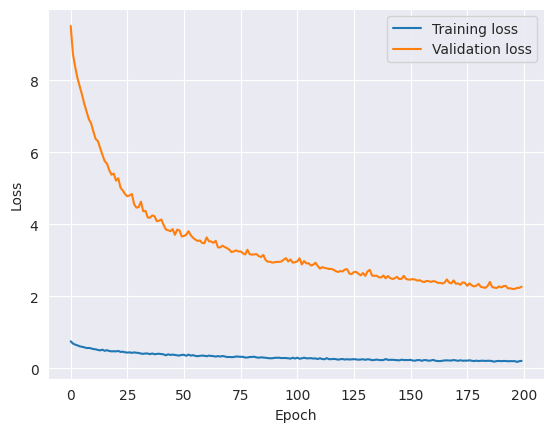

In [8]:
mlp = MLP()
device = torch.device("cpu")
mlp.to(device)

criterion = nn.BCELoss()
list_train_loss, list_val_loss = [], []
best_val_loss = None
optimizer = optim.SGD(mlp.parameters(), lr=0.001)
patience = 10

patience_counter = 0
num_epochs =200

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    train_loss = 0.0
    val_loss = 0.0

    mlp.train()
    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        y_batch = y_batch.view(-1, 1)
        optimizer.zero_grad()
        outputs = mlp(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * X_batch.size(0)

    mlp.eval()
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            y_batch = y_batch.view(-1, 1)
            outputs = mlp(X_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item() * X_batch.size(0)

    train_loss /= len(train_dataset)
    val_loss /= len(val_loader)
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f'Epoch {epoch}, Training loss: {train_loss:.4f}, Validation loss: {val_loss:.4f}')

    list_train_loss.append(train_loss)
    list_val_loss.append(val_loss)

    val_score = val_loss
    if best_val_loss is None:
        best_val_loss = val_score 
        torch.save(mlp.state_dict(), "checkpoint.pt")
    elif best_val_loss < val_score: 
        patience_counter += 1
        print("Earlystopping Patience Counter:",patience_counter)
        if patience_counter == patience:
            break
    else:
        best_val_loss = val_score
        torch.save(mlp.state_dict(), "checkpoint.pt") 
        patience_counter = 0

sns.set_style("darkgrid")
plt.plot(list_train_loss, label="Training loss")
plt.plot(list_val_loss, label="Validation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [9]:
!pip install torcheval
from torcheval.metrics.functional import binary_f1_score
from torcheval.metrics.functional import binary_accuracy


model = MLP()
model.load_state_dict(torch.load('checkpoint.pt'))

predictions = []
ground_truths = []

model.eval()
with torch.no_grad():
    for inputs,labels in test_loader:
        outputs = model(inputs)
        predicted = torch.round(outputs)
        predictions.extend(predicted.tolist())
        ground_truths.extend(labels.tolist())

ground_truths = torch.tensor(ground_truths).to(torch.int64)
predictions = torch.tensor(predictions).to(torch.int64).squeeze(1)


f1_score = binary_f1_score(predictions,ground_truths)

accuracy = binary_accuracy(predictions,ground_truths)

print("F1-Score: {:.4f}\nAccuracy: {:.4f}".format(f1_score,accuracy))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.4/158.4 KB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.6/83.6 KB 10.6 MB/s eta 0:00:00
F1-Score: 0.9485
Accuracy: 0.9495


In [26]:
class MLP_for_Overfit(nn.Module):
    def __init__(self):
        super(MLP_for_Overfit, self).__init__()
        self.hidden_layer_1 = nn.Linear(13, 1000) 
        self.relu1 = nn.ReLU()

        self.hidden_layer_2 = nn.Linear(1000, 500)
        self.relu2 = nn.ReLU()

        self.output_layer = nn.Linear(500, 1) 
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out = self.hidden_layer_1(x)
        out = self.relu1(out)
   
        out = self.hidden_layer_2(out)
        out = self.relu2(out)
 
        out = self.output_layer(out)
        out = self.sigmoid(out)
        return out

Epoch 0, Training loss: 0.6532, Validation loss: 5.0473
Epoch 1, Training loss: 0.3723, Validation loss: 4.7569
Epoch 2, Training loss: 0.3179, Validation loss: 3.2591
Epoch 3, Training loss: 0.2203, Validation loss: 2.8725
Epoch 4, Training loss: 0.2035, Validation loss: 3.3119
Epoch 5, Training loss: 0.1766, Validation loss: 5.5186
Epoch 6, Training loss: 0.2017, Validation loss: 2.6916
Epoch 7, Training loss: 0.1539, Validation loss: 2.4243
Epoch 8, Training loss: 0.1327, Validation loss: 3.0367
Epoch 9, Training loss: 0.1330, Validation loss: 2.1402
Epoch 10, Training loss: 0.1193, Validation loss: 3.6653
Epoch 11, Training loss: 0.1174, Validation loss: 14.9664
Epoch 12, Training loss: 0.1327, Validation loss: 2.1035
Epoch 13, Training loss: 0.1011, Validation loss: 1.9567
Epoch 14, Training loss: 0.0949, Validation loss: 2.1367
Epoch 15, Training loss: 0.0934, Validation loss: 2.0347
Epoch 16, Training loss: 0.0896, Validation loss: 2.3899
Epoch 17, Training loss: 0.0886, Validat

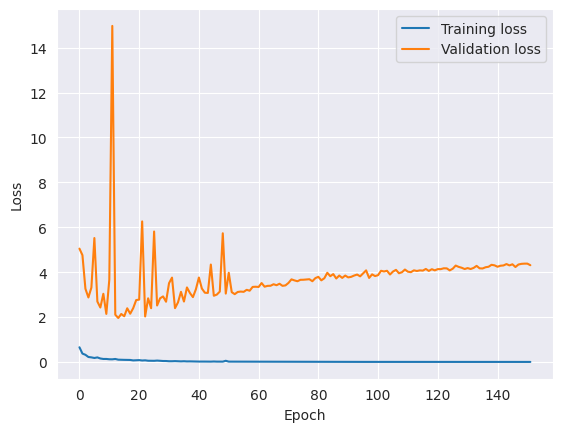

In [27]:
mlp = MLP_for_Overfit()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
mlp.to(device)

criterion = nn.BCELoss()
list_train_loss, list_val_loss = [], []

optimizer = optim.SGD(mlp.parameters(), lr=0.01)
num_epochs =152
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    train_loss = 0.0
    val_loss = 0.0

    mlp.train()
    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        y_batch = y_batch.view(-1, 1)
        optimizer.zero_grad()
        outputs = mlp(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * X_batch.size(0)

    mlp.eval()
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            y_batch = y_batch.view(-1, 1)
            outputs = mlp(X_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item() * X_batch.size(0)

    train_loss /= len(train_dataset)
    val_loss /= len(val_loader)
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f'Epoch {epoch}, Training loss: {train_loss:.4f}, Validation loss: {val_loss:.4f}')

    list_train_loss.append(train_loss)
    list_val_loss.append(val_loss)

sns.set_style("darkgrid")
plt.plot(list_train_loss, label="Training loss")
plt.plot(list_val_loss, label="Validation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()
    